In [208]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
#Reading Data
data = pd.read_excel('WaStEmployeeHistSalary.xlsx',skiprows=[0,1,2,3,4,5])
#Removing white spaces in Agency and Position columns
agency = []
position = []
for i in data.index:
    agency.append(data['Agency'][i].strip())
    position.append(data['Position'][i].strip())
data['Agency'] = agency
data['Position'] = position
#Calculating median salaries of all positions with atleast 5 records from 2013-2016. Positions not in each year are ignored.
data = data.replace(0, np.nan)
median_2013 = []
median_2014 = []
median_2015 = []
median_2016 = []
positions = []
for i in data['Position'].unique():
    salary_data = data[data['Position'] == i]
    if len(salary_data) >= 10:
        positions.append(i)
        median_2013.append(np.median(salary_data[2013].dropna()))
        median_2014.append(np.median(salary_data[2014].dropna()))
        median_2015.append(np.median(salary_data[2015].dropna()))
        median_2016.append(np.median(salary_data[2016].dropna()))
#Making dataframe of calculated median salaries
salary_data = pd.DataFrame([positions,median_2013,median_2014,median_2015,median_2016]).T.dropna()
salary_data.columns = ['Position',2013,2014,2015,2016]
salary_data[[2013,2014,2015,2016]] = salary_data[[2013,2014,2015,2016]].apply(pd.to_numeric)
#Calculating median salary growth for each position
salary_data['Growth_13-14'] = (salary_data[2014]-salary_data[2013])/salary_data[2013]
salary_data['Growth_14-15'] = (salary_data[2015]-salary_data[2014])/salary_data[2014]
salary_data['Growth_15-16'] = (salary_data[2016]-salary_data[2015])/salary_data[2015]
#Selecting top 5 position for plotting
highest_salary_positions = salary_data.nlargest(5,2016)
highest_salary_positions.set_index('Position',inplace=True)
highest_growth_positions = salary_data.nlargest(5,'Growth_15-16')
highest_growth_positions.set_index('Position',inplace=True)
#Getting Salary Data for Assistant, Associate and Full Professors at a university
university_data = data[data['Agency'] == 'University of Washington']
data_professor = university_data[university_data['Position'] == 'PROFESSOR']
data_assoc_professor = university_data[university_data['Position'] == 'ASSOCIATE PROFESSOR']
data_assist_professor = university_data[university_data['Position'] == 'ASSISTANT PROFESSOR']

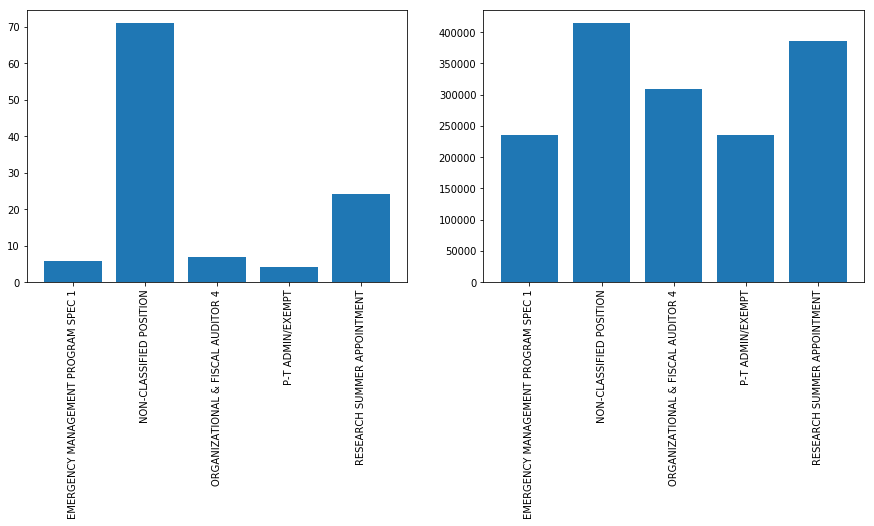

In [353]:
#Plot of top 5 highest salary and highest growth positions
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(x=highest_growth_positions.index,height=highest_growth_positions['Growth_15-16'])
ax2.bar(x=highest_growth_positions.index,height=highest_salary_positions[2016])
fig.set_size_inches(15,5)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
plt.show()

C:\Users\rahul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


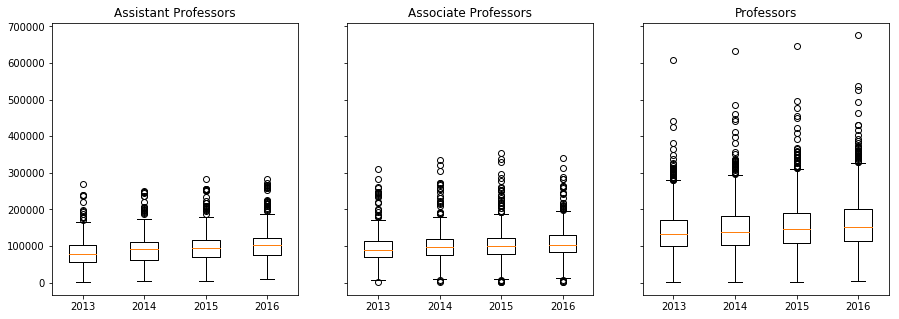

In [513]:
# Boxplots of faculty salaries
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True)
ax1.boxplot([data_assist_professor[2013].dropna(),data_assist_professor[2014].dropna(),data_assist_professor[2015].dropna(),data_assist_professor[2016].dropna()])
ax2.boxplot([data_assoc_professor[2013].dropna(),data_assoc_professor[2014].dropna(),data_assoc_professor[2015].dropna(),data_assoc_professor[2016].dropna()])
ax3.boxplot([data_professor[2013].dropna(),data_professor[2014].dropna(),data_professor[2015].dropna(),data_professor[2016].dropna()])
fig.set_size_inches(15,5)
ax1.set_xticklabels([2013,2014,2015,2016])
ax2.set_xticklabels([2013,2014,2015,2016])
ax3.set_xticklabels([2013,2014,2015,2016])
ax1.set_title('Assistant Professors')
ax2.set_title('Associate Professors')
ax3.set_title('Professors')
plt.savefig('Boxplots_Salary.png', bbox_inches='tight')
plt.show()

In [394]:
#Functions for web-scrapping Google Scholar website
def enter_search_search(driver,text):
    """
    Function to enter search string in search box
    Arguments:
        driver: Selenium web driver
        text (str): String to search
    Returns:
        None
    """
    WebDriverWait(driver,60).until(EC.presence_of_element_located((By.XPATH,'//*[@id="gs_hdr_tsi"]')))
    search_textbox = driver.find_element_by_xpath('//*[@id="gs_hdr_tsi"]')
    search_textbox.send_keys(text)
    WebDriverWait(driver,60).until(EC.presence_of_element_located((By.XPATH,'//*[@id="gs_hdr_tsb"]')))
    submit_button = driver.find_element_by_xpath('//*[@id="gs_hdr_tsb"]').click()
    return
def search_profiles(driver):
    """
    Function to search for profiles instead of articles
    Arguments:
        driver: Selenium web driver
    Returns:
        None
    """
    element = WebDriverWait(driver,60).until(EC.presence_of_element_located((By.XPATH,'//*[@id="gs_hdr_mnu"]')))
    driver.find_element_by_xpath('//*[@id="gs_hdr_mnu"]').send_keys("\n")
    WebDriverWait(driver,60).until(EC.presence_of_element_located((By.XPATH,'//*[@id="gs_hdr_drw_in"]/div[2]/div[1]/a[3]')))
    driver.find_element_by_xpath('//*[@id="gs_hdr_drw_in"]/div[2]/div[1]/a[3]').send_keys("\n")
    return
def get_citation(driver,prof_name,university_name):
    """
    Function to get total number of citations of a person
    Arguments:
        driver: Selenium web driver
        prof_name (str): Name of faculty to search
        university_name (str): University of the faculty
    Returns:
        n_citations (int): Total number of citations
    """
    driver.get("http://scholar.google.com")
    search_string = prof_name + ' ' + university_name
    enter_search_search(driver,search_string)
    search_profiles(driver)
    WebDriverWait(driver,np.random.randint(20,40)).until(EC.presence_of_element_located((By.XPATH,'//*[@id="gsc_sa_ccl"]/div[1]/div/div[3]')))
    n_citations = driver.find_element_by_xpath('//*[@id="gsc_sa_ccl"]/div[1]/div/div[3]').text.split()[-1]
    return n_citations

In [ ]:
# Web Scraping the Number of Citations from Google Scholar
#Full Professor Number of Citations
driver = webdriver.Chrome()
prof_name = []
citations = []
for i in data_professor['Name'][830:]:
    try:
        n_citations = get_citation(driver,i,'University of Washington')
        prof_name.append(i)
        citations.append(n_citations)
    except selenium.common.exceptions.TimeoutException:
        prof_name.append(i)
        citations.append(None)
prof_name = [i.strip() for i in prof_name]
citation_data = pd.DataFrame([prof_name,citations]).T
#Associate Professor Number of Citations
driver = webdriver.Chrome()
assoc_prof_name = []
assoc_citations = []
for i in data_assoc_professor['Name']:
    try:
        n_citations = get_citation(driver,i,'University of Washington')
        assoc_prof_name.append(i)
        assoc_citations.append(n_citations)
    except selenium.common.exceptions.TimeoutException:
        assoc_prof_name.append(i)
        assoc_citations.append(None)
assoc_prof_name = [i.strip() for i in assoc_prof_name]
assoc_citation_data = pd.DataFrame([assoc_prof_name,assoc_citations]).T
#Assistant Professor Number of Citations
driver = webdriver.Chrome()
assist_prof_name = []
assist_citations = []
for i in data_assist_professor['Name']:
    try:
        n_citations = get_citation(driver,i,'University of Washington')
        assist_prof_name.append(i)
        assist_citations.append(n_citations)
    except selenium.common.exceptions.TimeoutException:
        assist_prof_name.append(i)
        assist_citations.append(None)        
assist_prof_name = [i.strip() for i in assist_prof_name]
assist_citation_data = pd.DataFrame([assist_prof_name,assist_citations]).T

In [501]:
#Resetting index of all professor dataframes
data_professor.reset_index(inplace=True)
data_assoc_professor.reset_index(inplace=True)
data_assist_professor.reset_index(inplace=True)
#Adding 2016 Salary column
citation_data['Salary'] = data_professor[2016]
assoc_citation_data['Salary'] = data_assoc_professor[2016]
assist_citation_data['Salary'] = data_assist_professor[2016]
#Dropping all NA values
citation_data.dropna(inplace=True)
assoc_citation_data.dropna(inplace=True)
assist_citation_data.dropna(inplace=True)

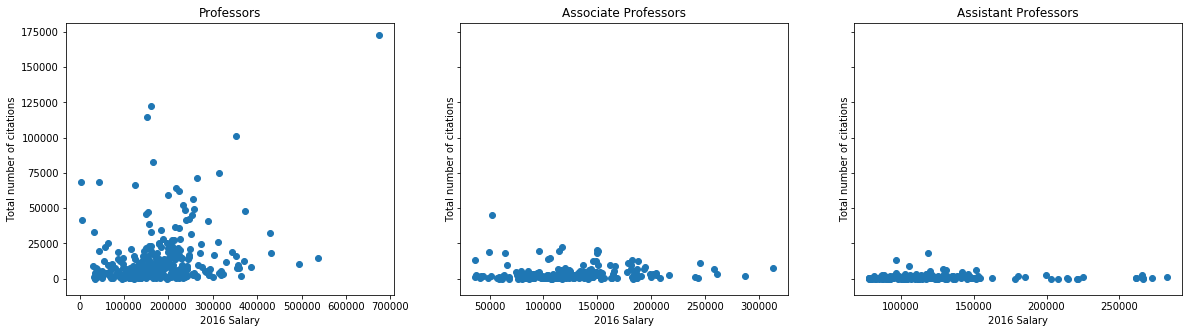

In [512]:
#Scatter plots of faculty salaries vs total citations
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True)
ax1.scatter(citation_data['Salary'],citation_data[1].astype('int'))
ax2.scatter(assoc_citation_data['Salary'],assoc_citation_data[1].astype('int'))
ax3.scatter(assist_citation_data['Salary'],assist_citation_data[1].astype('int'))
fig.set_size_inches(20,5)
ax1.set_title('Professors')
ax2.set_title('Associate Professors')
ax3.set_title('Assistant Professors')
ax1.set(xlabel='2016 Salary', ylabel='Total number of citations')
ax2.set(xlabel='2016 Salary', ylabel='Total number of citations')
ax3.set(xlabel='2016 Salary', ylabel='Total number of citations')
plt.savefig('Salary_vs_Citations.png', bbox_inches='tight')
plt.show()

In [504]:
slope, intercept, r_value, p_value, std_err = linregress(citation_data['Salary'],citation_data[1].astype('int'))
print('\nP-value of linear regression of Full Professor Salary vs Number of Citations: %.10f'%p_value)

slope, intercept, r_value, p_value, std_err = linregress(assoc_citation_data['Salary'],assoc_citation_data[1].astype('int'))
print('\nP-value of linear regression of Associate Professor Salary vs Number of Citations: %.10f'%p_value)

slope, intercept, r_value, p_value, std_err = linregress(assist_citation_data['Salary'],assist_citation_data[1].astype('int'))
print('\nP-value of linear regression of Assistant Professor Salary vs Number of Citations: %.10f'%p_value)


P-value of linear regression of Full Professor Salary vs Number of Citations: 0.0000000006

P-value of linear regression of Associate Professor Salary vs Number of Citations: 0.2477401099

P-value of linear regression of Assistant Professor Salary vs Number of Citations: 0.5873334857
